This notebook demonstrates how to use the global_sampler class to perform an MCMC analysis of EDGES data. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

import corner

sys.path.append(os.path.abspath('../edges/'))
import global_sampler as GS

/Users/dlenz/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


To initialize our sampler, we simply create an isntance of the Sampler class that points to our configuration file. The configuration file allows you to specify the order of the foreground polynomial, which terms to vary (or hold fixed), and also options for MCMC length, number of walkers, etc...

In [2]:
sampler = GS.Sampler('../config/example.yaml')

In [9]:
outdir = sampler.config['PROJECT_NAME']
outdir

'test_mcmc'

Here is the filtered variance compared to the square of the EDGES residual. 

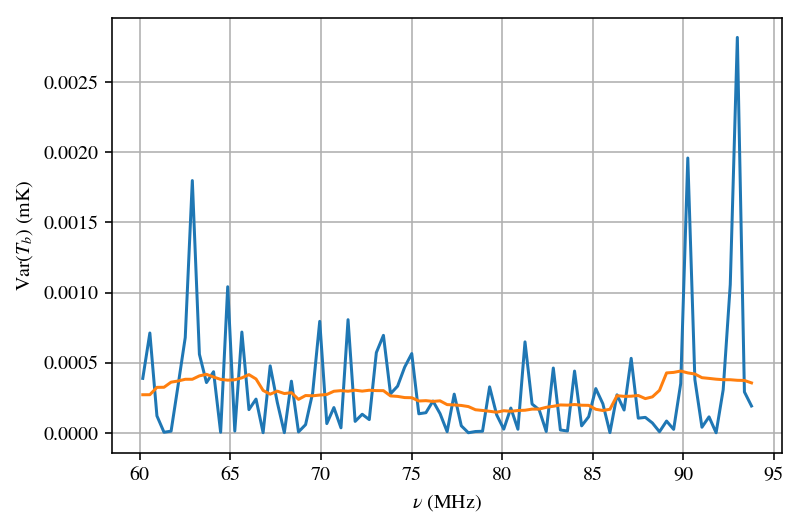

In [3]:
plt.plot(sampler.freqs,np.abs(sampler.dtb)**2.)
plt.plot(sampler.freqs,sampler.var_tb)
plt.grid()
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('Var($T_b$) (mK)');

To fit the data and perform MCMC, just call sampler.sample().

In [4]:
print(type(sampler.config['COMPUTECOVARIANCE']))

<class 'bool'>


In [5]:
sampler.sample()

Lets take a look at the chains (after removing the burn-in). 

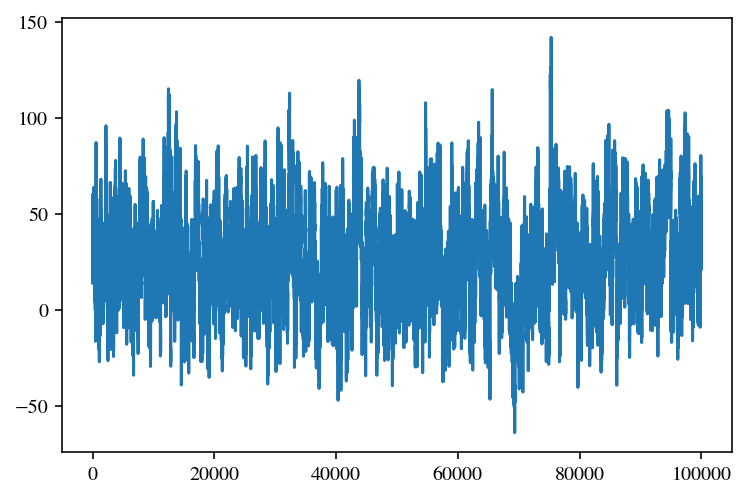

In [6]:
samples = sampler.sampler.chain.reshape(
    (-1, sampler.ndim))
plt.plot(samples[:, 8])

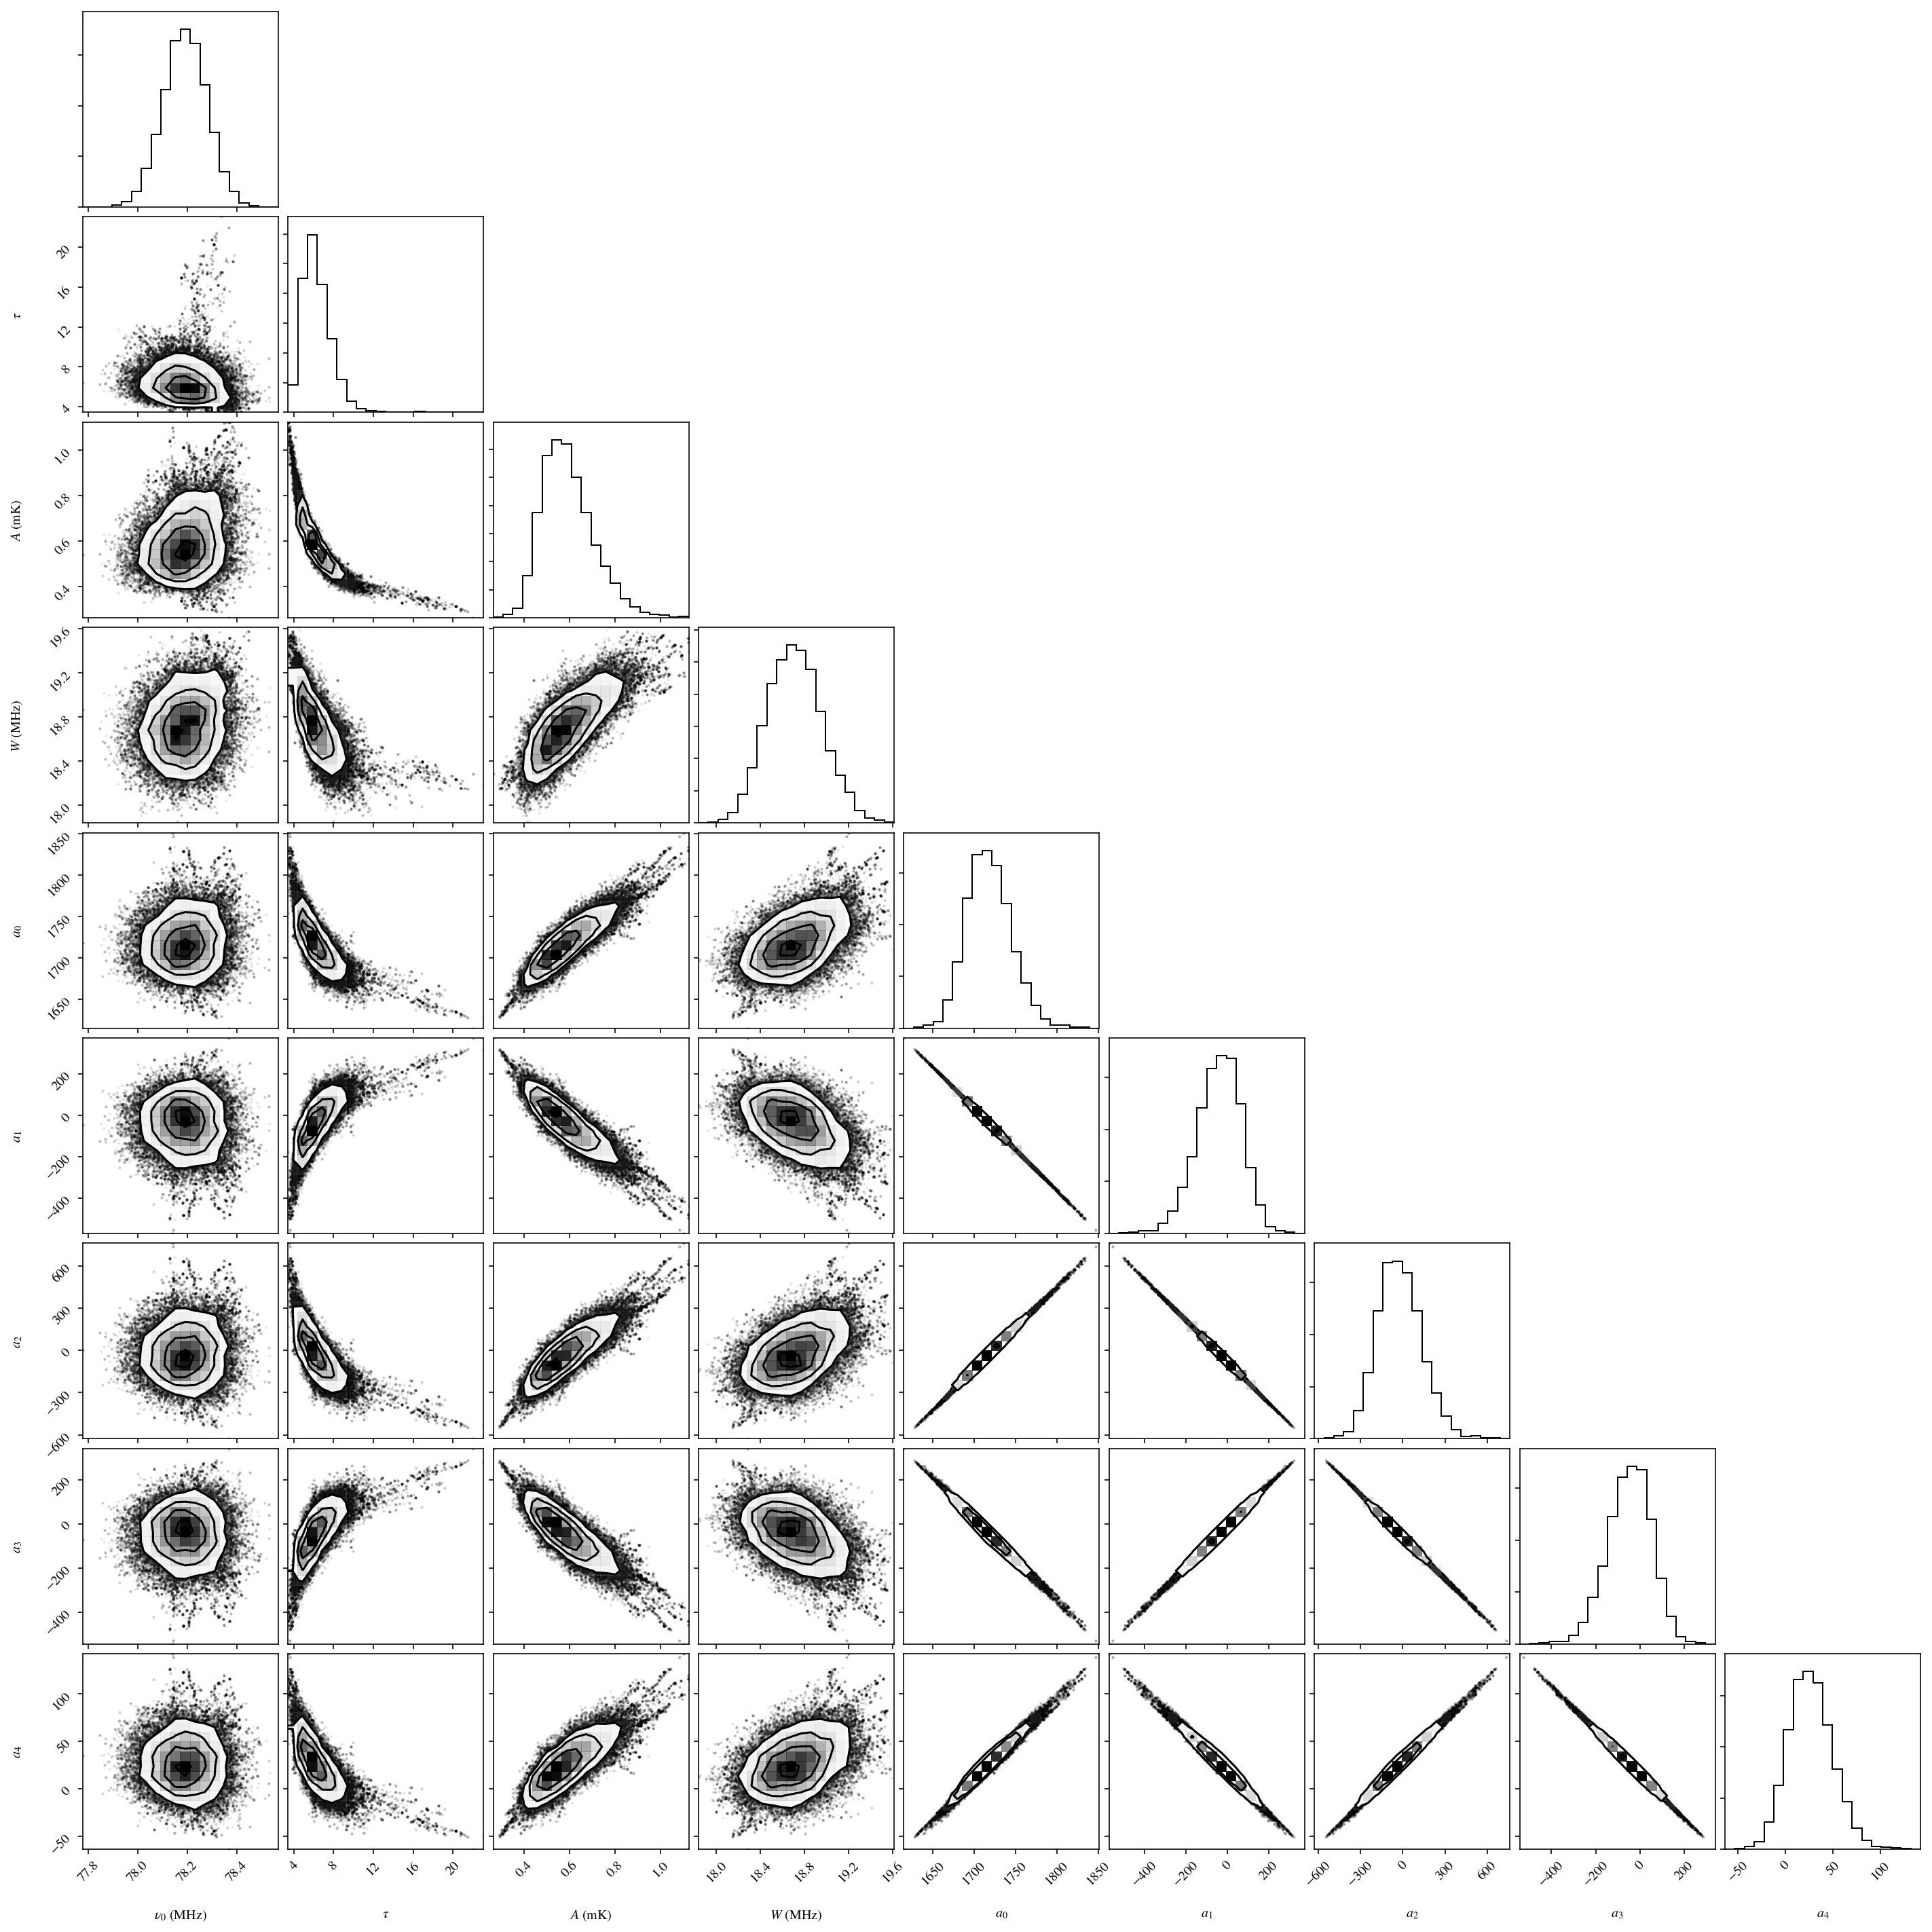

In [11]:
corner.corner(
    samples,
    labels=('$\\nu_0$ (MHz)','$\\tau$','$A$ (mK)','$W$ (MHz)','$a_0$','$a_1$','$a_2$','$a_3$','$a_4$'));

plt.savefig(os.path.join(outdir, 'triangle.pdf'), dpi=300);

Plot the maximum likelihood model, some draws, and the model

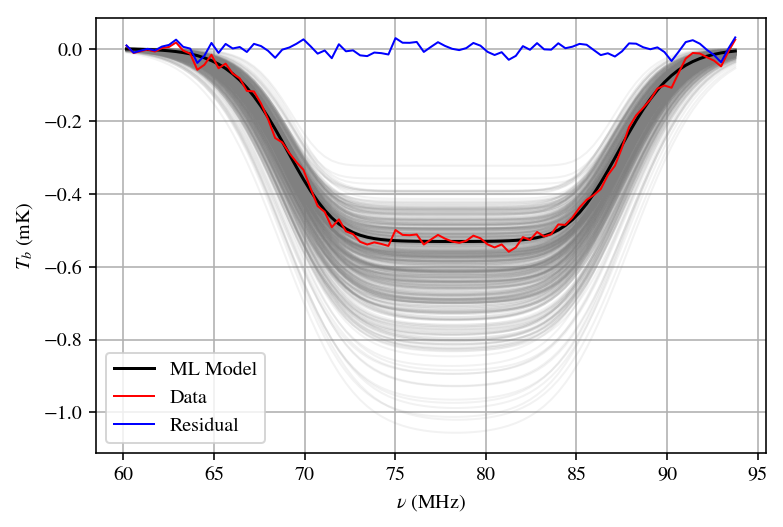

In [10]:
ndraws = 500

for drawnum in range(ndraws):
    draw = np.random.randint(0,sampler.config['NSTEPS']*sampler.config['NWALKERS'])
    params = {'NU0':samples[draw,0],'TAU':samples[draw,1],'A':samples[draw,2],'W':samples[draw,3]}
    
    plt.plot(
        sampler.freqs,
        GS.delta_Tb_analytic(sampler.freqs,**params),
        color='grey', lw=1, alpha=.1)

plt.plot(
    sampler.freqs,
    GS.TbSky(sampler.ml_params,sampler.freqs,sampler.params_all,[])\
        -GS.Tbfg(sampler.freqs,sampler.params_all),
    color='k', label='ML Model')

plt.plot(
    sampler.freqs,
    sampler.tb_meas-GS.Tbfg(sampler.freqs,sampler.params_all),
    color='r', lw=1, label='Data')
# l3=plt.plot(sampler.freqs,sampler.tb_meas-GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
# sampler.params_all,[],sampler.analytic),color='blue',lw=1)[0]
plt.plot(
    sampler.freqs,
    sampler.resid,
    color='blue', lw=1, label='Residual')

# Labels & legends
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('$T_b$ (mK)')
plt.legend()
plt.grid()

# Save
plt.savefig(os.path.join(outdir, 'recovered_signal.pdf'), dpi=300)